## Geha+25, Figure 1:  All-Sky

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

from astropy import table
from astropy.table import Table
from astropy.io import ascii
import astropy.constants
from astropy.coordinates import SkyCoord
import astropy.units as u

In [3]:
plt.rcParams.update({
    "figure.dpi": 200,
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "font.size": 17,
    "axes.labelsize": 17,
    "lines.markersize": 5,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 7,
    "xtick.minor.size": 4,
    "ytick.major.size": 7,
    "ytick.minor.size": 4,
    "savefig.bbox": "tight",
    "savefig.dpi": 200,
})

In [4]:
######################################################
# READ DEIMOS OBJECT GOOGLE DOCUMENT
def deimos_google():
    key = '1V2aVg1QghpQ70Lms40zNUjcCrycBF2bjgs-mrp6ojI8'
    gid=1906496323
    url = 'https://docs.google.com/spreadsheets/d/{0}/export?format=csv&gid={1}'.format(key, gid)
    masklist = Table.read(url, format='csv')

    gid =0
    url = 'https://docs.google.com/spreadsheets/d/{0}/export?format=csv&gid={1}'.format(key, gid)
    objlist = ascii.read(url, format='csv')
    
    return objlist,masklist


######################################################
# READ DEIMOS OBJECT GOOGLE DOCUMENT
def deimos_google_M31():
    key = '1V2aVg1QghpQ70Lms40zNUjcCrycBF2bjgs-mrp6ojI8'
    gid=237917397
    url = 'https://docs.google.com/spreadsheets/d/{0}/export?format=csv&gid={1}'.format(key, gid)
    masklist = Table.read(url, format='csv')

    gid =180140955
    url = 'https://docs.google.com/spreadsheets/d/{0}/export?format=csv&gid={1}'.format(key, gid)
    objlist = ascii.read(url, format='csv')
    
    m=objlist['Project'] == 'M31'
    return objlist[m],masklist


In [5]:
DateObs_18mon = 20231201

# READ DEIMOS OBJECT IN GOOGLE DOCUMENT
objlist, masklist      = deimos_google()
m = objlist['Project'] == 'MW'
objlist=objlist[m]

m  = (masklist['DateObs'] < DateObs_18mon) & (masklist['pypeit_redux'] != 'N') &\
                 (masklist['pypeit_redux'] != 'S')&(masklist['Project'] == 'MW')
masklist=masklist[m]

m31_objlist, m31_masklist = deimos_google_M31()
m=m31_objlist['Project'] == 'M31'
m31_objlist = m31_objlist[m]


In [6]:
ntot_mw = 0

# Count masks FOR MW FIRST
mw_mask = []
for obj in objlist:
    
    m = masklist['Object'] == obj['Name2']
    mw_mask.append(np.sum(m))
    ntot_mw = ntot_mw + np.sum(m)

mw_mask = np.array(mw_mask)

#  then m31
m31_mask = []
ntot_m31 = 0
for obj in m31_objlist:
    
    m = m31_masklist['Object'] == obj['Name2']
    m31_mask.append(np.sum(m))
    ntot_m31= ntot_m31 + np.sum(m)
    
m31_mask = np.array(m31_mask)

In [7]:
def convert_radec2radian(RA,Dec,origin=0):
    
    x = np.remainder(RA+360-origin,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x            # reverse the scale: East to the left

    xrad = np.radians(x)
    yrad = np.radians(Dec)
    
    return xrad,yrad

In [8]:
glat = np.arange(0,360,1)*u.degree+207.*u.degree
glon = np.zeros(np.size(glat))*u.degree
c = SkyCoord(l=glat,b=glon,frame='galactic')
gplane = c.transform_to('icrs') 

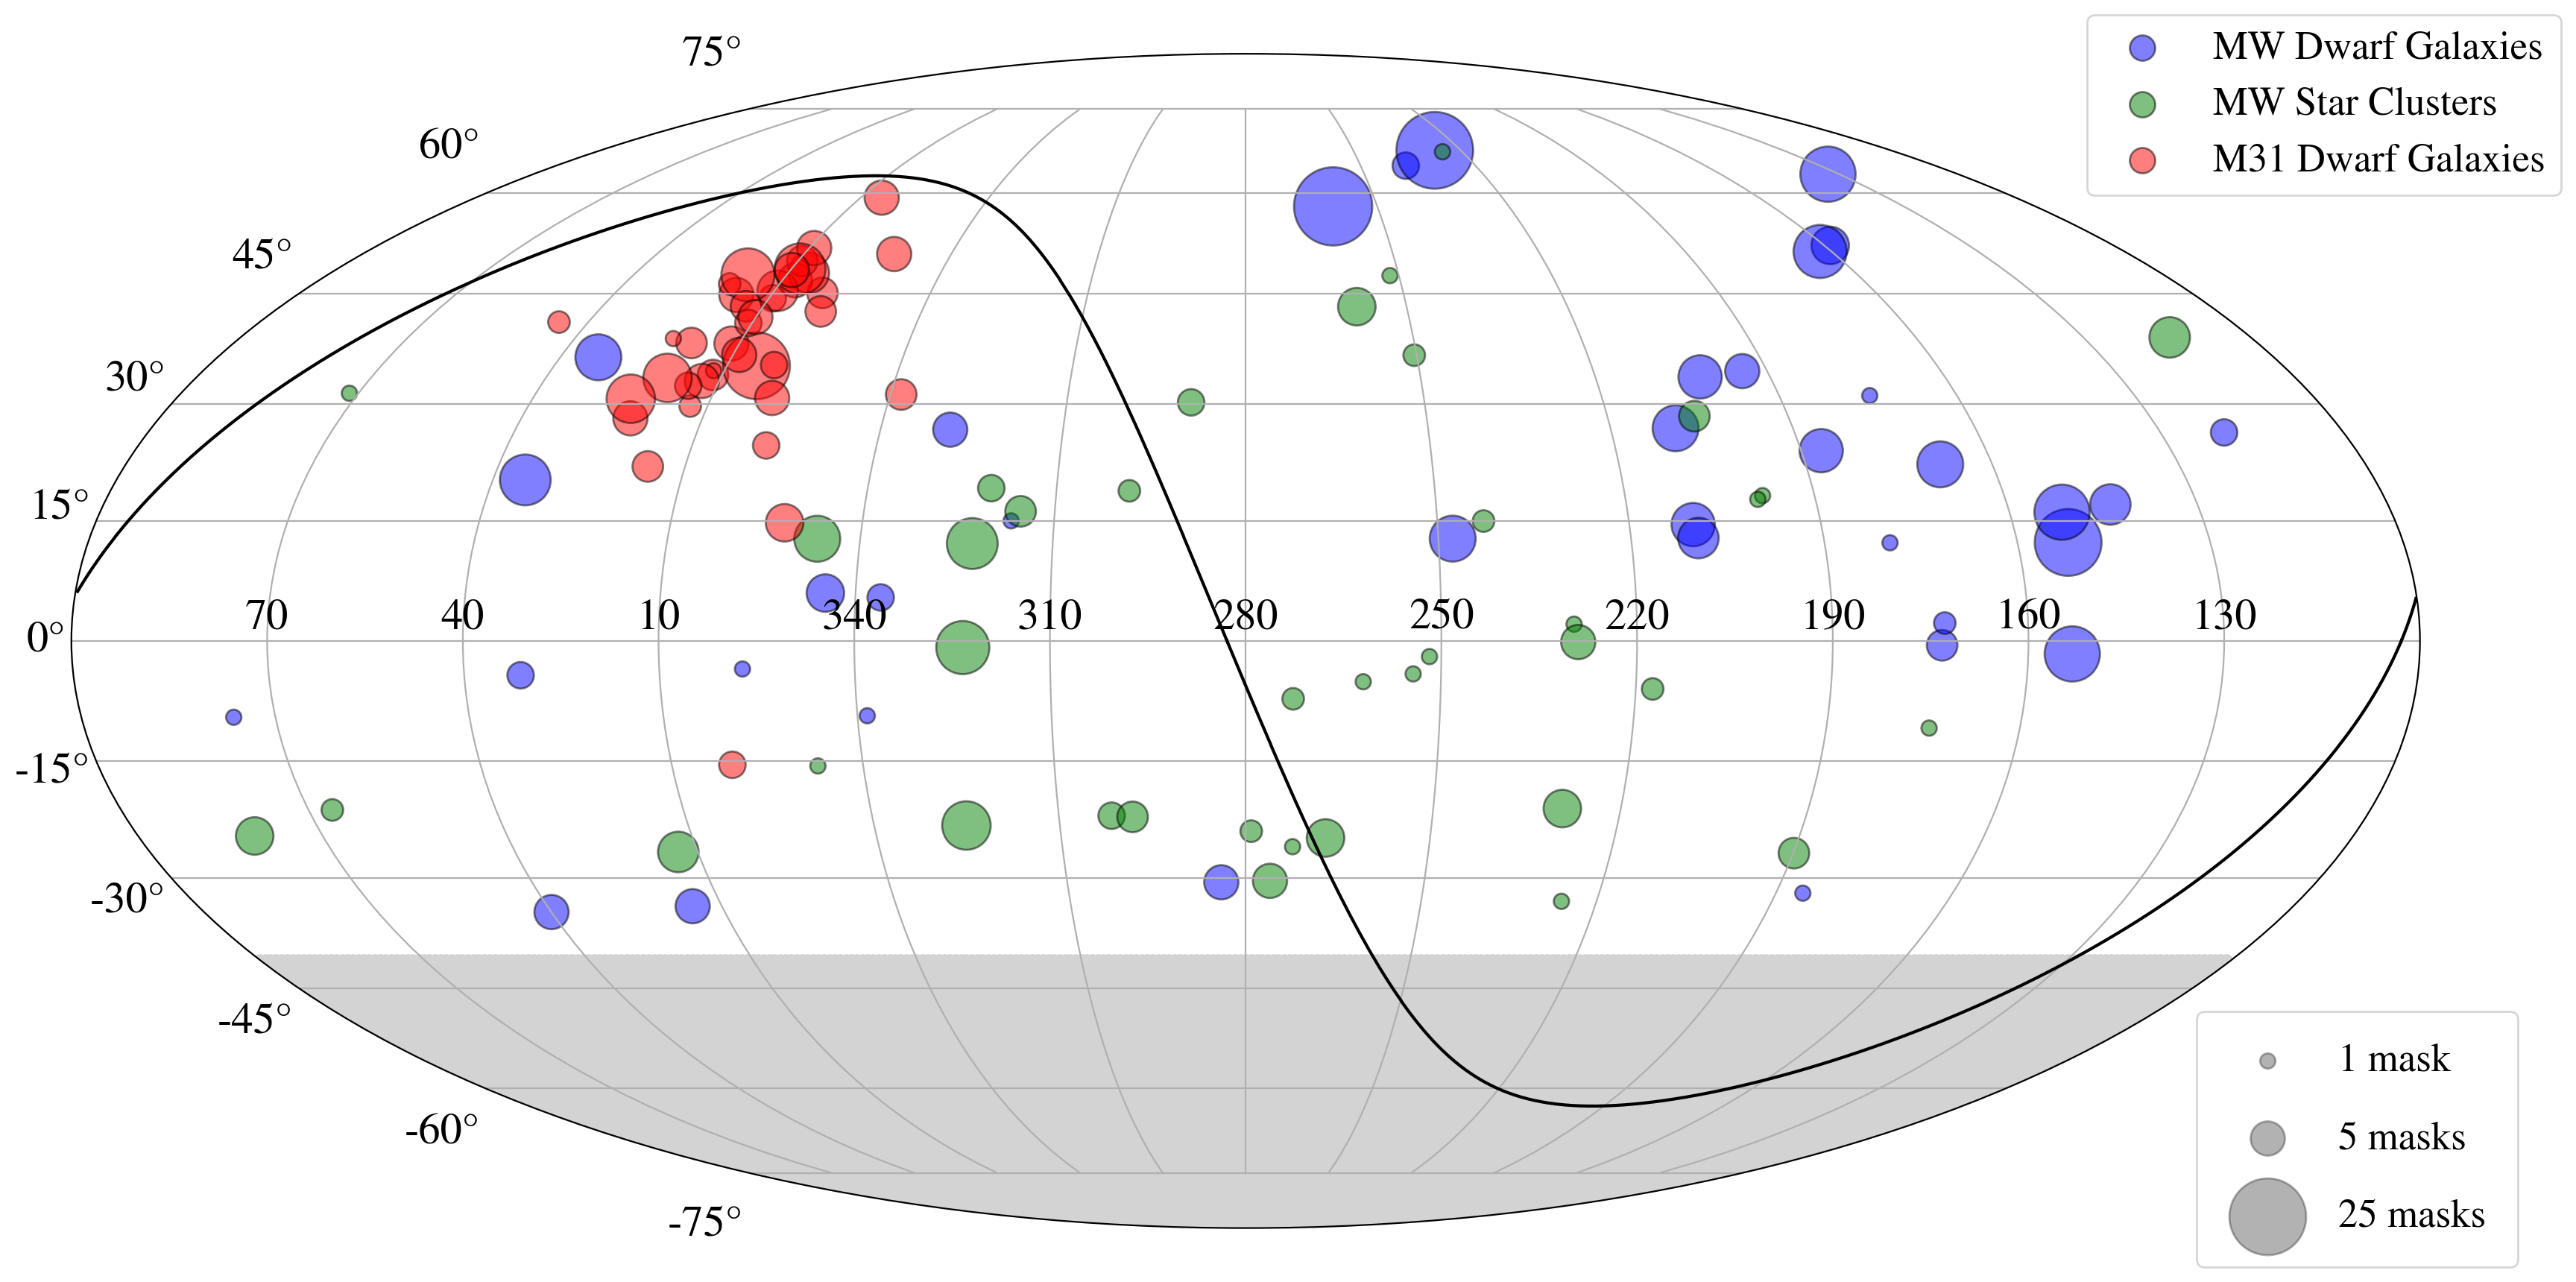

In [9]:
origin = 280.
fig=plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size': 21})

ax = fig.add_subplot(111, projection='mollweide')

tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+origin,360)

# PLOT GALAXY PLANE
xg,yg = convert_radec2radian(gplane.ra.degree,gplane.dec.degree,origin=origin)
ax.plot(xg,yg,'k')
ax.grid(True)

scl = 55
xh,yh = convert_radec2radian(objlist['RA'],objlist['Dec'],origin=origin)

m=objlist['Type'] != 'GC'
ax.scatter(xh[m],yh[m],s=scl*mw_mask[m], facecolors='b',\
           edgecolors='k',alpha=0.5,label='MW Dwarf Galaxies')

m=objlist['Type'] == 'GC'
ax.scatter(xh[m],yh[m],s=scl*mw_mask[m], facecolors='g',\
           edgecolors='k',alpha=0.5,label='MW Star Clusters')


#M31
xh,yh = convert_radec2radian(m31_objlist['RA'],m31_objlist['Dec'],origin=origin)
ax.scatter(xh,yh,s=scl*m31_mask, facecolors='r',\
           edgecolors='k',alpha=0.5,label='M31 Dwarf Galaxies')


lgnd = ax.legend(markerscale=1.1,fontsize=19,bbox_to_anchor=(0.85, 1.05))
lgnd.legendHandles[0]._sizes = [150]
lgnd.legendHandles[1]._sizes = [150]
lgnd.legendHandles[2]._sizes = [150]
ax.add_artist(lgnd)

ax.set_xticklabels(tick_labels.astype(int)) 

south = np.arange(-89,-40,1)
ra = np.arange(0,360,1)
for d in south:
    ra = np.arange(0,360,1)
    dec = np.ones(360)*d
    xh,yh = convert_radec2radian(ra,dec,origin=origin)
    ax.scatter(xh,yh,facecolor='lightgray',rasterized=True)

# CREATE SECOND LEGEND    
for size in [1, 5, 25]:
        if size == 1:
            lgnd2 = plt.scatter([], [], c='k', alpha=0.3, s=scl*size,
                       label=str(size) + ' mask')
        if size > 1:
            lgnd2 = plt.scatter([], [], c='k', alpha=0.3, s=scl*size,
                       label=str(size) + ' masks')
            
            
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:],loc=4,fontsize=19,bbox_to_anchor=(1.05, -0.05),\
          borderpad=0.8,labelspacing=1.05)



plt.tight_layout()
plt.savefig('/Users/mg37/Desktop/figure_allsky.pdf')
#plt.savefig('figure_allsky.pdf')


In [10]:
print('Max/Min number of MW masks: ',np.max(m31_mask),np.max(mw_mask))
print('Median number of MW masks:  ',np.median([mw_mask]))

Max/Min number of MW masks:  19 26
Median number of MW masks:   3.0
